<a href="https://colab.research.google.com/github/abstractguy/lstm_autoencoder_classifier/blob/master/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install --upgrade twython

In [6]:
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finviz_url = 'https://finviz.com/quote.ashx?t='

In [8]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [9]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Dow Jones Futures: Why The Market Rally Is So Strong; Tesla Holds Buy Point Despite Bad News
Sep-05-21 12:24PM  
New Investor? Here Are 3 Great Starter Stocks
11:49AM  
Cathie Wood Goes Bargain-Hunting: 3 Stocks She Just Bought
11:10AM  
Don't Count on Social Security: 2 Smart Stocks to Help You Retire
08:30AM  


In [10]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN',
  'Sep-05-21',
  '12:24PM',
  'Dow Jones Futures: Why The Market Rally Is So Strong; Tesla Holds Buy Point Despite Bad News'],
 ['AMZN',
  'Sep-05-21',
  '11:49AM',
  'New Investor? Here Are 3 Great Starter Stocks'],
 ['AMZN',
  'Sep-05-21',
  '11:10AM',
  'Cathie Wood Goes Bargain-Hunting: 3 Stocks She Just Bought'],
 ['AMZN',
  'Sep-05-21',
  '08:30AM',
  "Don't Count on Social Security: 2 Smart Stocks to Help You Retire"],
 ['AMZN',
  'Sep-05-21',
  '07:35AM',
  '3 Game-Changing Stocks That Could Turn $100,000 to $1 Million by 2035'],
 ['AMZN',
  'Sep-05-21',
  '07:20AM',
  '3 No-Brainer Stocks to Buy and Hold for the Next Decade'],
 ['AMZN',
  'Sep-04-21',
  '09:45AM',
  "Macy's Stock Nearly Doubled This Year: 2 Catalysts That Could Send It Higher"],
 ['AMZN', 'Sep-04-21', '09:13AM', 'Buy UPS on a Dip?'],
 ['AMZN',
  'Sep-04-21',
  '09:07AM',
  '10 Reddit YOLO Stocks That Are Losing Ground'],
 ['AMZN',
  'Sep-04-21',
  '09:06AM',
  'Flipkart co-founder challenges Indian e

In [12]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [13]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2021-09-05,12:24PM,Dow Jones Futures: Why The Market Rally Is So ...,0.0,0.700,0.300,0.7538
1,AMZN,2021-09-05,11:49AM,New Investor? Here Are 3 Great Starter Stocks,0.0,0.594,0.406,0.6249
2,AMZN,2021-09-05,11:10AM,Cathie Wood Goes Bargain-Hunting: 3 Stocks She...,0.0,1.000,0.000,0.0000
3,AMZN,2021-09-05,08:30AM,Don't Count on Social Security: 2 Smart Stocks...,0.0,0.506,0.494,0.7783
4,AMZN,2021-09-05,07:35AM,"3 Game-Changing Stocks That Could Turn $100,00...",0.0,1.000,0.000,0.0000


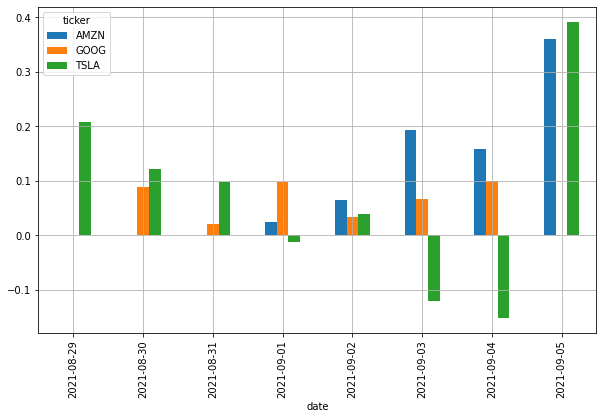

In [14]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()